In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
FOLDERNAME='Assignment4'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
!pip install wandb torch torchvision matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import wandb
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import helpers.data_loader as data_loader
train_loader, val_loader, test_df=data_loader.get_complete_fer_setup()

In [ ]:
wandb.login()
results={}
models={}

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: skara21 (skara21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import helpers.model_train as model_train
import helpers.model_analyser as model_analyser

In [ ]:
class ResNetBlock_NoReg(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_NoReg, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=True)
        self.conv2=nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=True)

        self.shortcut=nn.Sequential()

        if stride!=1 or in_channels!=out_channels:
          self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=True))

    def forward(self, x):
        identity=self.shortcut(x)
        out=F.relu(self.conv1(x))
        out=self.conv2(out)
        out+=identity
        out=F.relu(out)
        return out

class ResNetBlock_BatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_BatchNorm, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.conv2=nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)

        self.bn1=nn.BatchNorm2d(out_channels)
        self.bn2=nn.BatchNorm2d(out_channels)

        self.shortcut=nn.Sequential()

        if stride!=1 or in_channels!=out_channels:
            self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity=self.shortcut(x)
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out+=identity
        out=F.relu(out)
        return out

class ResNetBlock_Both(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.1):
        super(ResNetBlock_Both, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.conv2=nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)

        self.bn1=nn.BatchNorm2d(out_channels)
        self.bn2=nn.BatchNorm2d(out_channels)

        self.dropout1=nn.Dropout2d(dropout_rate)
        self.dropout2=nn.Dropout2d(dropout_rate)

        self.shortcut=nn.Sequential()

        if stride!=1 or in_channels!=out_channels:
            self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity=self.shortcut(x)
        out=self.dropout1(F.relu(self.bn1(self.conv1(x))))
        out=self.dropout2(self.bn2(self.conv2(out)))
        out+=identity
        out=F.relu(out)
        return out

In [ ]:
class HybridCNN_NoReg(nn.Module):
    def __init__(self, num_classes=7):
        super(HybridCNN_NoReg, self).__init__()

        self.conv1=nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1=nn.MaxPool2d(2, 2)

        self.resblock1=ResNetBlock_NoReg(32, 64, stride=1)
        self.resblock2=ResNetBlock_NoReg(64, 64, stride=1)
        self.pool2=nn.MaxPool2d(2, 2)

        self.resblock3=ResNetBlock_NoReg(64, 128, stride=1)
        self.resblock4=ResNetBlock_NoReg(128, 128, stride=1)
        self.pool3=nn.MaxPool2d(2, 2)

        self.avgpool=nn.AdaptiveAvgPool2d((1, 1))

        self.fc=nn.Linear(128, num_classes)

    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=self.pool1(x)

        x=self.resblock1(x)
        x=self.resblock2(x)
        x=self.pool2(x)

        x=self.resblock3(x)
        x=self.resblock4(x)
        x=self.pool3(x)

        x=self.avgpool(x)
        x=x.view(x.size(0), -1)

        x=self.fc(x)

        return x


🔬 EXPERIMENT 1/4 : Best Architecture -No Regularization


Epoch  0: Train: 24.9%/1.804, Val: 24.5%/1.790, Gap: -0.014
Epoch  5: Train: 54.2%/1.204, Val: 55.8%/1.163, Gap: -0.041
Epoch 10: Train: 67.8%/0.851, Val: 61.0%/1.054, Gap: 0.203
Epoch 15: Train: 89.1%/0.308, Val: 62.9%/1.569, Gap: 1.261
Epoch 20: Train: 99.7%/0.019, Val: 63.1%/2.881, Gap: 2.862
Epoch 24: Train: 99.8%/0.005, Val: 63.2%/3.131, Gap: 3.127


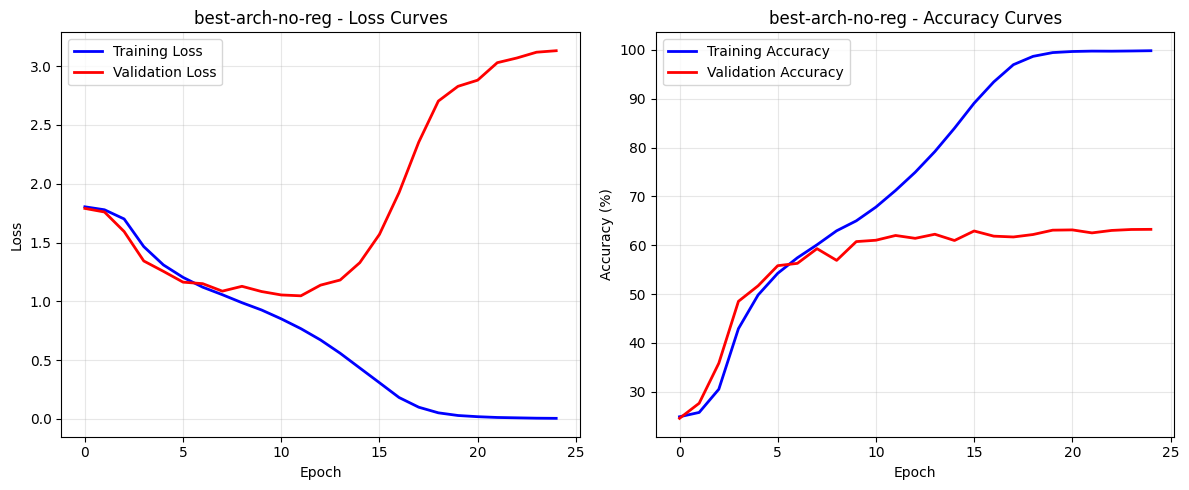

accuracy_gap,▂▁▂▃▄▆███
epoch,▁▂▃▄▅▅▆▇█
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▂▅██▆▅▃▁▁


In [ ]:
print("\n🔬 EXPERIMENT 1/4 : Best Architecture -No Regularization")

model_no_reg=HybridCNN_NoReg(num_classes=7)
results_no_reg=model_train.train_model_regularization(
    model=model_no_reg,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="best-arch-no-reg",
    device=device,
    epochs=25
)
results['no_reg']=results_no_reg
models['no_reg']=model_no_reg

In [ ]:
class HybridCNN_Dropout(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(HybridCNN_Dropout, self).__init__()

        self.conv1=nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.pool1=nn.MaxPool2d(2, 2)
        self.dropout1=nn.Dropout2d(dropout_rate * 0.5)

        self.resblock1=ResNetBlock_NoReg(32, 64, stride=1)
        self.resblock2=ResNetBlock_NoReg(64, 64, stride=1)

        self.pool2=nn.MaxPool2d(2, 2)
        self.dropout2=nn.Dropout2d(dropout_rate * 0.5)

        self.resblock3=ResNetBlock_NoReg(64, 128, stride=1)
        self.resblock4=ResNetBlock_NoReg(128, 128, stride=1)

        self.pool3=nn.MaxPool2d(2, 2)
        self.dropout3=nn.Dropout2d(dropout_rate * 0.5)

        self.avgpool=nn.AdaptiveAvgPool2d((1, 1))

        self.dropout_fc=nn.Dropout(dropout_rate)

        self.fc=nn.Linear(128, num_classes)


    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))

        x=self.pool1(x)
        x=self.dropout1(x)

        x=self.resblock1(x)
        x=self.resblock2(x)

        x=self.pool2(x)
        x=self.dropout2(x)

        x=self.resblock3(x)
        x=self.resblock4(x)

        x=self.pool3(x)
        x=self.dropout3(x)

        x=self.avgpool(x)
        x=x.view(x.size(0), -1)

        x=self.dropout_fc(x)
        x=self.fc(x)

        return x


🔬 EXPERIMENT 2/4: Best Architecture -Dropout Only


Epoch  0: Train: 22.7%/1.842, Val: 24.5%/1.796, Gap: -0.046
Epoch  5: Train: 43.0%/1.460, Val: 48.1%/1.362, Gap: -0.097
Epoch 10: Train: 53.3%/1.225, Val: 55.6%/1.167, Gap: -0.058
Epoch 15: Train: 59.4%/1.070, Val: 59.2%/1.073, Gap: 0.003
Epoch 20: Train: 64.6%/0.923, Val: 60.7%/1.047, Gap: 0.124
Epoch 24: Train: 66.7%/0.873, Val: 61.3%/1.048, Gap: 0.176


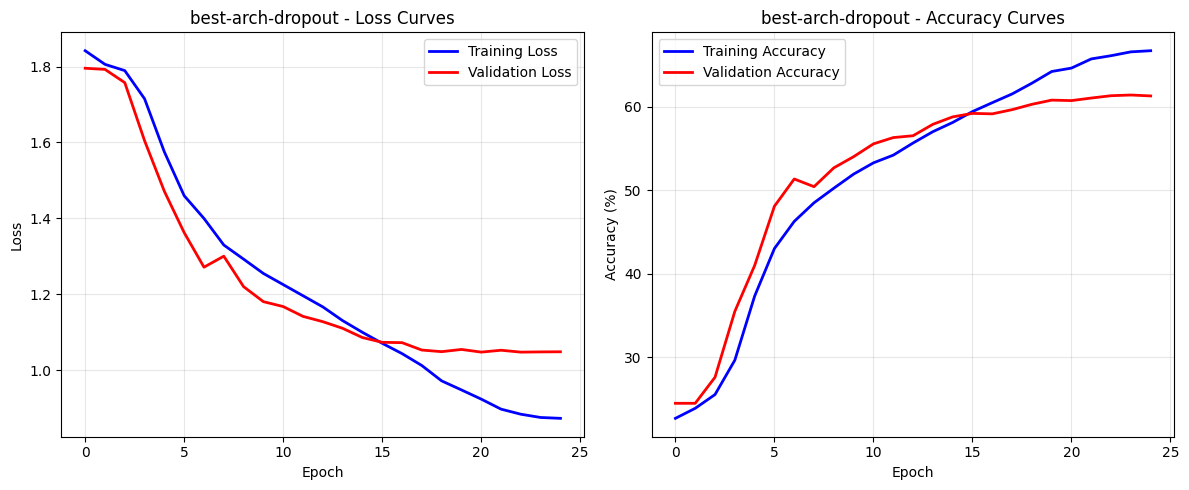

accuracy_gap,▄▁▁▃▄▅▆██
epoch,▁▂▃▄▅▅▆▇█
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▂▅██▆▅▃▁▁


In [ ]:
print("\n🔬 EXPERIMENT 2/4: Best Architecture -Dropout Only")

model_dropout=HybridCNN_Dropout(num_classes=7, dropout_rate=0.5)
results_dropout=model_train.train_model_regularization(
    model=model_dropout,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="best-arch-dropout",
    device=device,
    epochs=25
)
results['dropout']=results_dropout
models['dropout']=model_dropout

In [ ]:
class HybridCNN_BatchNorm(nn.Module):
    def __init__(self, num_classes=7):
        super(HybridCNN_BatchNorm, self).__init__()

        self.conv1=nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(32)

        self.resblock1=ResNetBlock_BatchNorm(32, 64, stride=1)
        self.resblock2=ResNetBlock_BatchNorm(64, 64, stride=1)
        self.resblock3=ResNetBlock_BatchNorm(64, 128, stride=1)
        self.resblock4=ResNetBlock_BatchNorm(128, 128, stride=1)

        self.pool1=nn.MaxPool2d(2, 2)
        self.pool2=nn.MaxPool2d(2, 2)
        self.pool3=nn.MaxPool2d(2, 2)

        self.avgpool=nn.AdaptiveAvgPool2d((1, 1))
        self.fc=nn.Linear(128, num_classes)

    def forward(self, x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool1(x)

        x=self.resblock1(x)
        x=self.resblock2(x)

        x=self.pool2(x)

        x=self.resblock3(x)
        x=self.resblock4(x)

        x=self.pool3(x)

        x=self.avgpool(x)
        x=x.view(x.size(0), -1)

        x=self.fc(x)

        return x


🔬 EXPERIMENT 3/4: Best Architecture -Batch Normalization Only


Epoch  0: Train: 35.3%/1.636, Val: 40.6%/1.536, Gap: -0.100
Epoch  5: Train: 61.3%/1.025, Val: 56.9%/1.170, Gap: 0.145
Epoch 10: Train: 74.8%/0.685, Val: 56.5%/1.525, Gap: 0.841
Epoch 15: Train: 95.9%/0.130, Val: 60.5%/1.773, Gap: 1.643
Epoch 20: Train: 99.7%/0.018, Val: 65.3%/1.747, Gap: 1.729
Epoch 24: Train: 99.8%/0.006, Val: 65.5%/1.757, Gap: 1.751


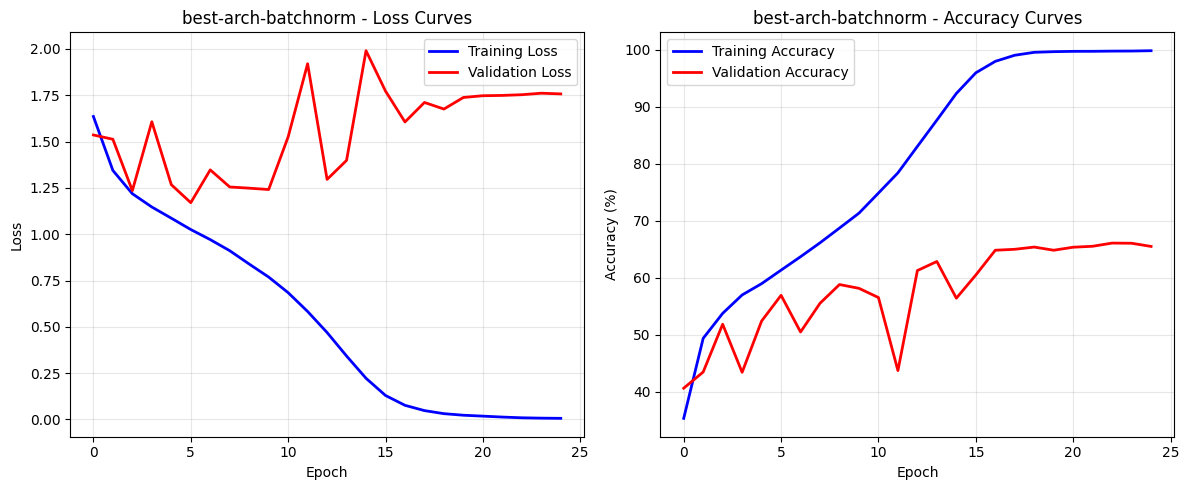

accuracy_gap,▁▄▄▄▆████
epoch,▁▂▃▄▅▅▆▇█
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▂▅██▆▅▃▁▁


In [ ]:
print("\n🔬 EXPERIMENT 3/4: Best Architecture -Batch Normalization Only")

model_batchnorm=HybridCNN_BatchNorm(num_classes=7)
results_batchnorm=model_train.train_model_regularization(
    model=model_batchnorm,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="best-arch-batchnorm",
    device=device,
    epochs=25
)
results['batchnorm']=results_batchnorm
models['batchnorm']=model_batchnorm

In [ ]:
class HybridCNN_Both(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(HybridCNN_Both, self).__init__()

        self.conv1=nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(32)

        self.pool1=nn.MaxPool2d(2, 2)
        self.pool2=nn.MaxPool2d(2, 2)
        self.pool3=nn.MaxPool2d(2, 2)

        self.dropout1=nn.Dropout2d(dropout_rate * 0.3)
        self.dropout2=nn.Dropout2d(dropout_rate * 0.3)
        self.dropout3=nn.Dropout2d(dropout_rate * 0.3)

        self.resblock1=ResNetBlock_Both(32, 64, stride=1, dropout_rate=dropout_rate * 0.3)
        self.resblock2=ResNetBlock_Both(64, 64, stride=1, dropout_rate=dropout_rate * 0.3)
        self.resblock3=ResNetBlock_Both(64, 128, stride=1, dropout_rate=dropout_rate * 0.3)
        self.resblock4=ResNetBlock_Both(128, 128, stride=1, dropout_rate=dropout_rate * 0.3)

        self.avgpool=nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_fc=nn.Dropout(dropout_rate)
        self.fc=nn.Linear(128, num_classes)

    def forward(self, x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))

        x=self.pool1(x)
        x=self.dropout1(x)

        x=self.resblock1(x)
        x=self.resblock2(x)

        x=self.pool2(x)
        x=self.dropout2(x)

        x=self.resblock3(x)
        x=self.resblock4(x)

        x=self.pool3(x)
        x=self.dropout3(x)

        x=self.avgpool(x)
        x=x.view(x.size(0), -1)

        x=self.dropout_fc(x)
        x=self.fc(x)

        return x



🔬 EXPERIMENT 4/4: Best Architecture -Both Regularization Techniques


Epoch  0: Train: 21.3%/1.995, Val: 25.8%/1.772, Gap: -0.223
Epoch  5: Train: 45.8%/1.403, Val: 50.8%/1.269, Gap: -0.133
Epoch 10: Train: 56.6%/1.147, Val: 58.7%/1.064, Gap: -0.083
Epoch 15: Train: 62.9%/0.990, Val: 62.9%/0.976, Gap: -0.014
Epoch 20: Train: 67.8%/0.859, Val: 65.3%/0.936, Gap: 0.077
Epoch 24: Train: 69.8%/0.810, Val: 65.6%/0.933, Gap: 0.123


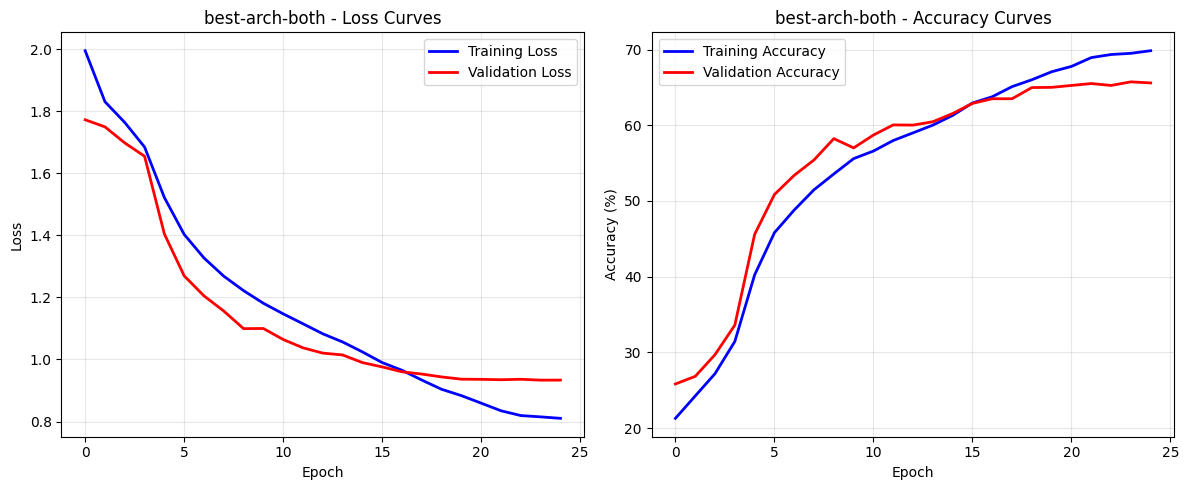

accuracy_gap,▁▃▁▄▄▅▅▇█
epoch,▁▂▃▄▅▅▆▇█
final/best_val_accuracy,▁
final/final_acc_gap,▁
final/final_loss_gap,▁
final/final_train_accuracy,▁
final/final_val_accuracy,▁
final/overfitting_score,▁
final/total_epochs,▁
final/total_parameters,▁
learning_rate,▂▅██▆▅▃▁▁


In [ ]:
print("\n🔬 EXPERIMENT 4/4: Best Architecture -Both Regularization Techniques")

model_both=HybridCNN_Both(num_classes=7, dropout_rate=0.4)
results_both=model_train.train_model_regularization(
    model=model_both,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="best-arch-both",
    device=device,
    epochs=25
)
results['both']=results_both
models['both']=model_both

გავაანალიზოთ შედეგები!

In [ ]:
print("Analyzing results: ")

results_df = pd.DataFrame([
    {
        'Regularization': result['regularization_type'],
        'Best_Val_Acc': result['best_val_accuracy'],
        'Final_Train_Acc': result['final_train_accuracy'],
        'Final_Val_Acc': result['final_val_accuracy'],
        'Acc_Gap': result['final_acc_gap'],
        'Loss_Gap': result['final_loss_gap'],
        'Status': result['model_status'],
        'Effectiveness': result['regularization_effectiveness'],
        'Epochs': result['total_epochs']
    }
    for result in results.values()
])

print(results_df.to_string(index=False, float_format='%.2f'))


baseline_acc_gap = results['no_reg']['final_acc_gap']
baseline_loss_gap = results['no_reg']['final_loss_gap']
baseline_key = 'no_reg'


for method, result in results.items():
    if method == baseline_key:
        continue

    current_acc_gap = result['final_acc_gap']
    current_loss_gap = result['final_loss_gap']

    acc_improvement = baseline_acc_gap - current_acc_gap
    loss_improvement = baseline_loss_gap - current_loss_gap
    val_acc_change = result['final_val_accuracy'] - results[baseline_key]['final_val_accuracy']

    print(f"\n{result['regularization_type'].upper()}:")
    print(f"  Overfitting Reduction:")
    print(f"    Acc Gap: {current_acc_gap:.1f}% vs {baseline_acc_gap:.1f}% (Δ{acc_improvement:+.1f}%)")
    print(f"    Loss Gap: {current_loss_gap:.3f} vs {baseline_loss_gap:.3f} (Δ{loss_improvement:+.3f})")
    print(f"  Performance Impact:")
    print(f"    Val Accuracy: {result['final_val_accuracy']:.1f}% (Δ{val_acc_change:+.1f}%)")
    print(f"  Overall: {result['regularization_effectiveness']}")

Analyzing results: 
          Regularization  Best_Val_Acc  Final_Train_Acc  Final_Val_Acc  Acc_Gap  Loss_Gap       Status        Effectiveness  Epochs
       No Regularization         63.25            99.83          63.25    36.58     -3.13  OVERFITTING             Baseline      25
            Dropout Only         61.41            66.71          61.30     5.42     -0.18 GOOD_BALANCE Moderately Effective      25
Batch Normalization Only         66.06            99.83          65.48    34.35     -1.75  OVERFITTING        Not Effective      25
Both Dropout + BatchNorm         65.73            69.84          65.59     4.25     -0.12 GOOD_BALANCE Moderately Effective      25

DROPOUT ONLY:
  Overfitting Reduction:
    Acc Gap: 5.4% vs 36.6% (Δ+31.2%)
    Loss Gap: -0.176 vs -3.127 (Δ-2.951)
  Performance Impact:
    Val Accuracy: 61.3% (Δ-2.0%)
  Overall: Moderately Effective

BATCH NORMALIZATION ONLY:
  Overfitting Reduction:
    Acc Gap: 34.3% vs 36.6% (Δ+2.2%)
    Loss Gap: -1.751 vs -3

Vizualization:


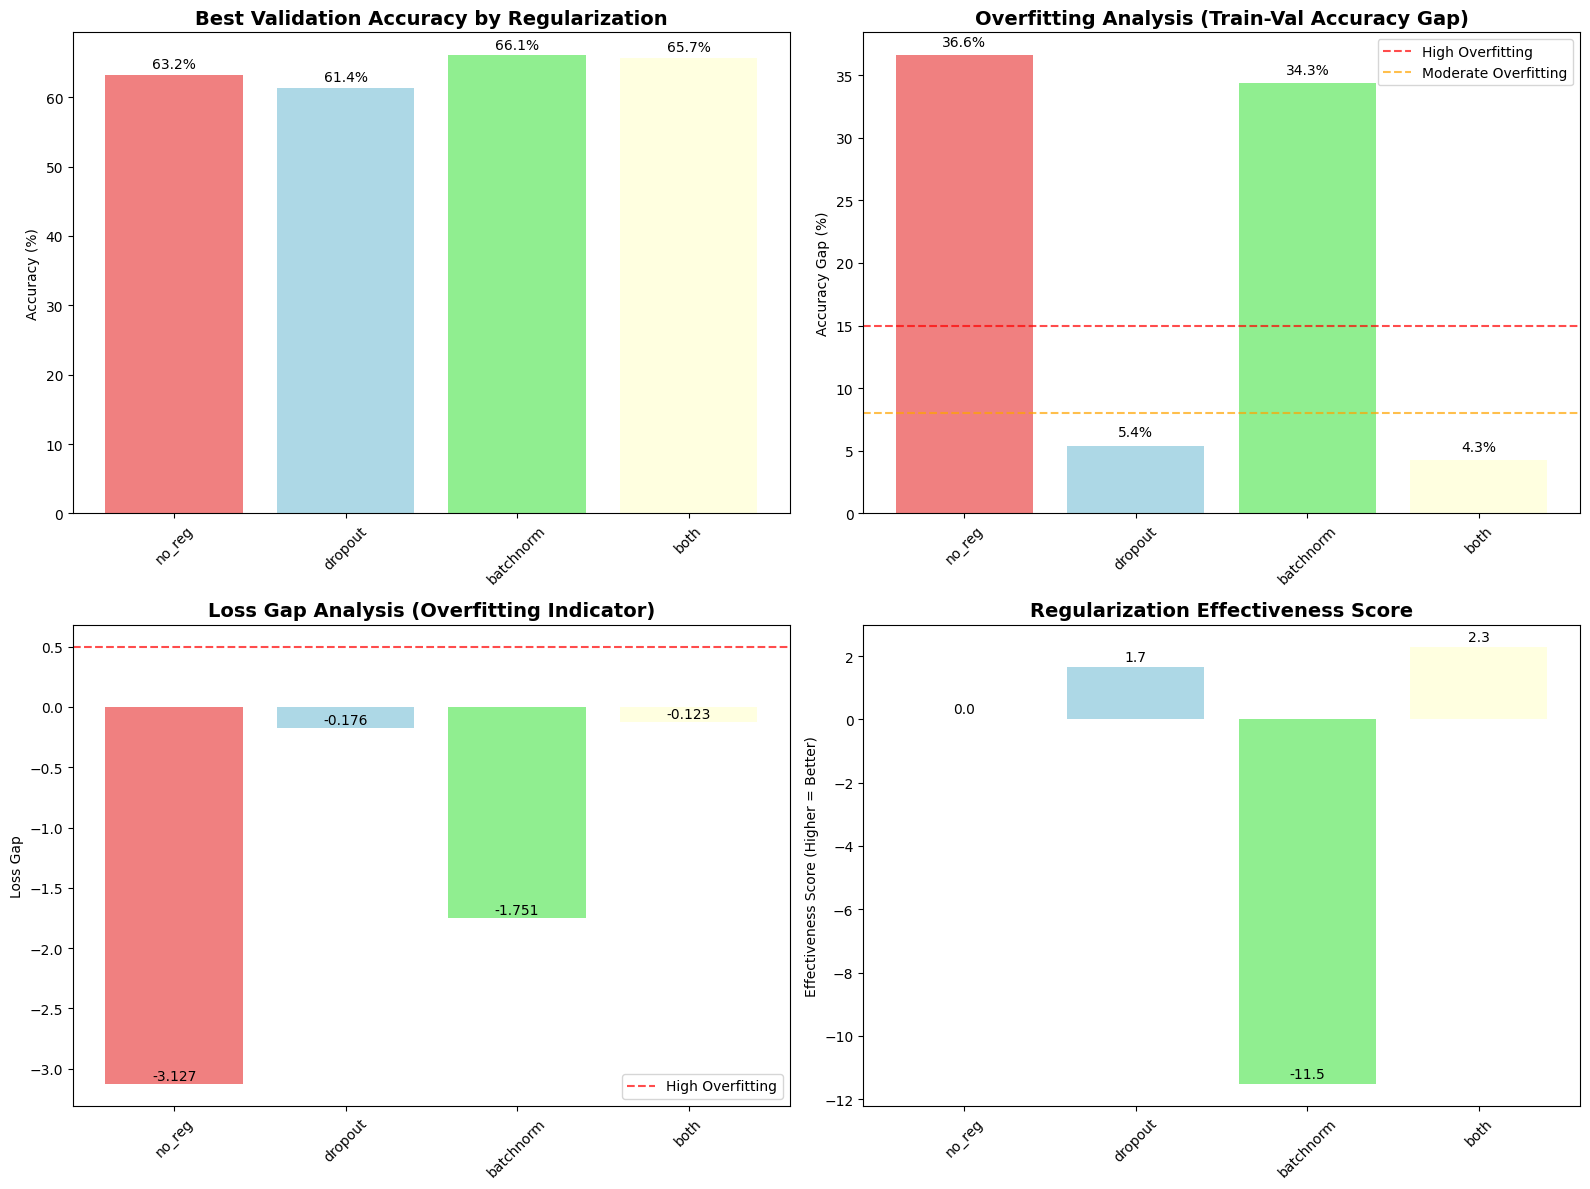

In [ ]:
print("Vizualization:")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

methods = list(results.keys())
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'][:len(methods)]

# 1. Validation Accuracy Comparison
val_accs = [results[method]['best_val_accuracy'] for method in methods]
bars1 = ax1.bar(methods, val_accs, color=colors)
ax1.set_title('Best Validation Accuracy by Regularization', fontweight='bold', fontsize=14)
ax1.set_ylabel('Accuracy (%)')
ax1.tick_params(axis='x', rotation=45)
for bar, acc in zip(bars1, val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
              f'{acc:.1f}%', ha='center', va='bottom')

# 2. Overfitting Reduction (Accuracy Gap)
acc_gaps = [results[method]['final_acc_gap'] for method in methods]
bars2 = ax2.bar(methods, acc_gaps, color=colors)
ax2.set_title('Overfitting Analysis (Train-Val Accuracy Gap)', fontweight='bold', fontsize=14)
ax2.set_ylabel('Accuracy Gap (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='High Overfitting')
ax2.axhline(y=8, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting')
ax2.legend()
for bar, gap in zip(bars2, acc_gaps):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
              f'{gap:.1f}%', ha='center', va='bottom')

# 3. Loss Gap Comparison
loss_gaps = [results[method]['final_loss_gap'] for method in methods]
bars3 = ax3.bar(methods, loss_gaps, color=colors)
ax3.set_title('Loss Gap Analysis (Overfitting Indicator)', fontweight='bold', fontsize=14)
ax3.set_ylabel('Loss Gap')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='High Overfitting')
ax3.legend()
for bar, gap in zip(bars3, loss_gaps):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
              f'{gap:.3f}', ha='center', va='bottom')

# 4. Regularization Effectiveness Score
effectiveness_scores = []
for method in methods:
    if method == baseline_key:
        effectiveness_scores.append(0)  # Baseline
    else:
        # Calculate effectiveness score
        acc_reduction = baseline_acc_gap - results[method]['final_acc_gap']
        loss_reduction = baseline_loss_gap - results[method]['final_loss_gap']
        effectiveness_scores.append(acc_reduction + loss_reduction * 10)  # Scale loss reduction

bars4 = ax4.bar(methods, effectiveness_scores, color=colors)
ax4.set_title('Regularization Effectiveness Score', fontweight='bold', fontsize=14)
ax4.set_ylabel('Effectiveness Score (Higher = Better)')
ax4.tick_params(axis='x', rotation=45)
for bar, score in zip(bars4, effectiveness_scores):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
              f'{score:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
print("Final reccomendation:")

best_method = max(results.keys(), key=lambda x: results[x]['best_val_accuracy'])
least_overfitted = min(results.keys(), key=lambda x: results[x]['final_acc_gap'])
most_effective=max([k for k in results.keys() if k!='no_reg'],
                    key=lambda x: baseline_acc_gap - results[x]['final_acc_gap'])

print(f"Best performing: {results[best_method]['regularization_type']} ({results[best_method]['best_val_accuracy']:.2f}%)")
print(f"Least overfitted: {results[least_overfitted]['regularization_type']} (gap: {results[least_overfitted]['final_acc_gap']:.1f}%)")
print(f"Most effective regularization: {results[most_effective]['regularization_type']}")

print(f"Final hyphotesis:")
if results[most_effective]['final_acc_gap'] < baseline_acc_gap - 3:
    print("Regularization techniques reduce overfitting")
else:
    print("Limited overfitting reduction")

print("Final phase model architecture reccomendation:")
print(f"{results[best_method]['regularization_type']}")

Final reccomendation:
Best performing: Batch Normalization Only (66.06%)
Least overfitted: Both Dropout + BatchNorm (gap: 4.3%)
Most effective regularization: Both Dropout + BatchNorm
Final hyphotesis:
Regularization techniques reduce overfitting
Final phase model architecture reccomendation:
Batch Normalization Only


In [ ]:
model=models[best_method]
save_path='/content/drive/MyDrive/Assignment4/models/best_model.pth'

torch.save(model, save_path)

print(f"Model saved to: {save_path}")

Model saved to: /content/drive/MyDrive/Assignment4/models/best_model.pth
